In [ ]:
#LIBRERIAS
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tensorflow.keras import layers, models, regularizers
from keras.models import Sequential
from sklearn.metrics import confusion_matrix
import seaborn as sns
import collections

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
direccion = "../content/drive/MyDrive/Img_Preprocessing_Multi/"

datagen = ImageDataGenerator(rescale=1./255,
                             validation_split=0.2
                             )

train_data = datagen.flow_from_directory(direccion,
                                         target_size=(224,224),
                                         batch_size=32,
                                         class_mode = 'categorical',
                                         subset = 'training')


valid_data = datagen.flow_from_directory(direccion,
                                         target_size=(224,224),
                                         batch_size=32,
                                         class_mode = 'categorical',
                                         subset = 'validation')

Found 760 images belonging to 5 classes.
Found 190 images belonging to 5 classes.


In [ ]:
class_names = train_data.class_indices
print(class_names)

{'0_NO DR': 0, '1_MILD': 1, '2_MODERATE': 2, '3_SEVERE': 3, '4_PROLIFERATIVE DR': 4}


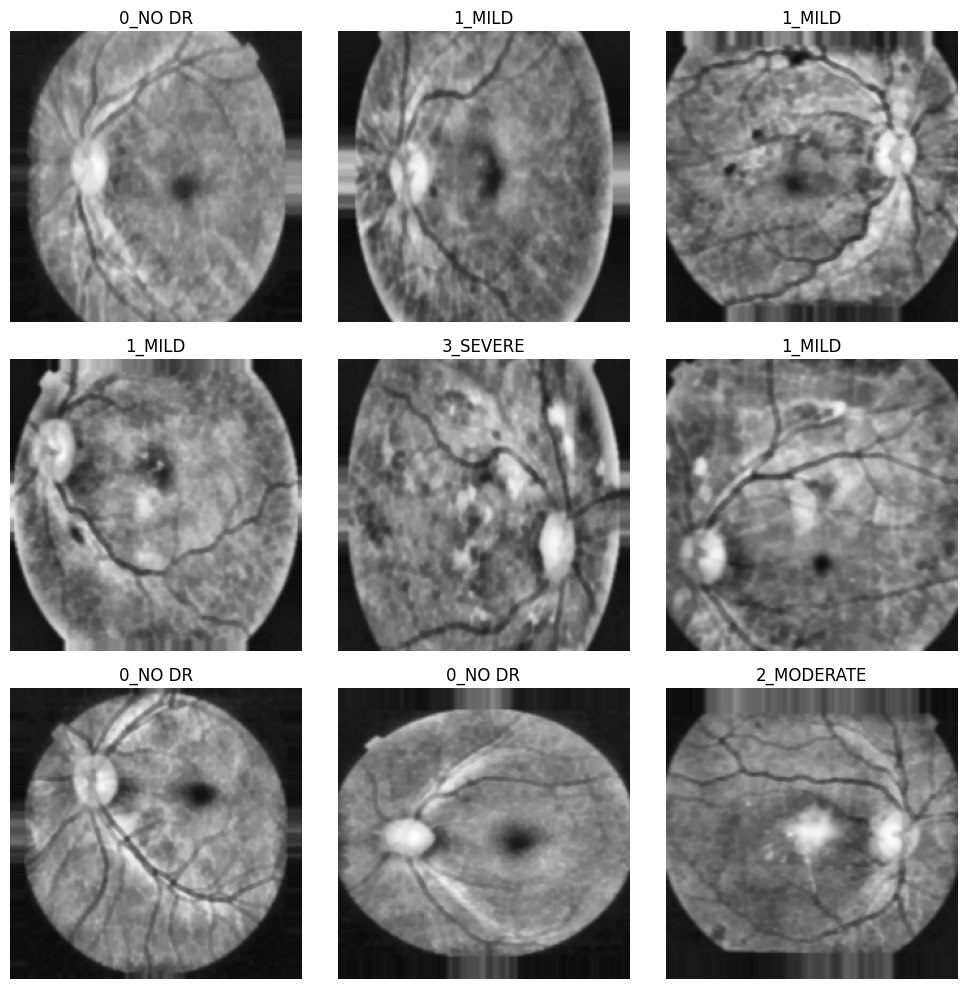

In [ ]:
images, labels = next(train_data)
class_names = list(train_data.class_indices.keys())

fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.flatten()

for img, label, ax in zip(images[:9], labels[:9], axes):
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(class_names[np.argmax(label)])

plt.tight_layout()
plt.show()

In [ ]:
!pip install -q efficientnet

In [ ]:
import efficientnet.tfkeras as efn

In [ ]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

In [ ]:
# model = tf.keras.Sequential([
#         efn.EfficientNetB0(
#             input_shape=(224,224, 3),
#             weights='imagenet',
#             include_top=False
#         ),tf.keras.layers.Flatten(),tf.keras.layers.Dense(5, activation='softmax')
#     ])

num_classes = 5

# model = tf.keras.Sequential([
#     #tf.keras.layers.Rescaling(1./255, input_shape=(224, 224, 3)),
#     tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001), input_shape=(224, 224, 3)),
#     tf.keras.layers.MaxPooling2D(),
#     tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#     tf.keras.layers.MaxPooling2D(),
#     tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#     tf.keras.layers.MaxPooling2D(),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(256, activation='relu'),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(num_classes, activation='softmax')
# ])


model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001), input_shape=(224, 224, 3)),
    tf.keras.layers.BatchNormalization(),  # Nueva capa
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.6),  # Aumentar dropout
    tf.keras.layers.Dense(num_classes, activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │      22,151,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,245,957 (84.86 MB)

 Trainable params: 22,245,957 (84.86 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer="Adam",loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history = model.fit(train_data,
                    validation_data = valid_data,
                    callbacks=[lr_scheduler],
                    epochs=40,
                    verbose=1)

Epoch 1/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 138s 5s/step - accuracy: 0.2173 - loss: 2.1875 - val_accuracy: 0.2947 - val_loss: 1.6443 - learning_rate: 0.0010
Epoch 2/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 134s 5s/step - accuracy: 0.3041 - loss: 1.6312 - val_accuracy: 0.3211 - val_loss: 1.4933 - learning_rate: 0.0010
Epoch 3/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 117s 5s/step - accuracy: 0.2833 - loss: 1.5649 - val_accuracy: 0.3211 - val_loss: 1.4584 - learning_rate: 0.0010
Epoch 4/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 120s 5s/step - accuracy: 0.3473 - loss: 1.5099 - val_accuracy: 0.3684 - val_loss: 1.4767 - learning_rate: 0.0010
Epoch 5/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 128s 5s/step - accuracy: 0.3932 - loss: 1.4567 - val_accuracy: 0.3684 - val_loss: 1.4383 - learning_rate: 0.0010
Epoch 6/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 119s 5s/step - accuracy: 0.4114 - loss: 1.4541 - val_accuracy: 0.4105 - val_loss: 1.4421 - learning_rate: 0.0010
Epoch 7/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 142s 5s/step - accuracy: 0.3362 - loss: 1.4500 - val_acc

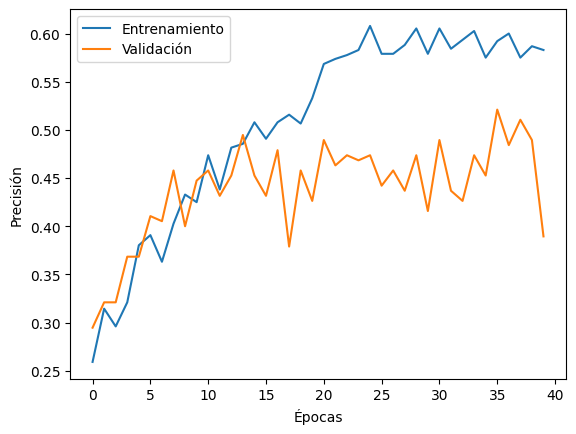

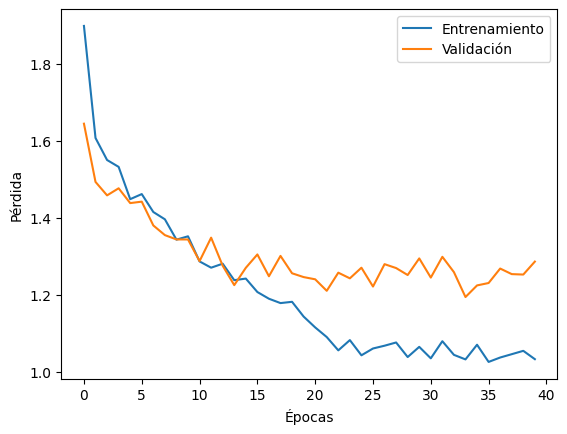

In [ ]:
# Gráfica de precisión
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

# Gráfica de pérdida
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [ ]:
y_true = valid_data.classes

# Obtener las predicciones del modelo
y_pred_probs = model.predict(valid_data)  # Suponiendo que ya tienes un modelo entrenado
y_pred = np.argmax(y_pred_probs, axis=1)  # Convertir probabilidades en etiquetas

# Obtener nombres de las clases
class_labels = list(valid_data.class_indices.keys())

# Crear la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step


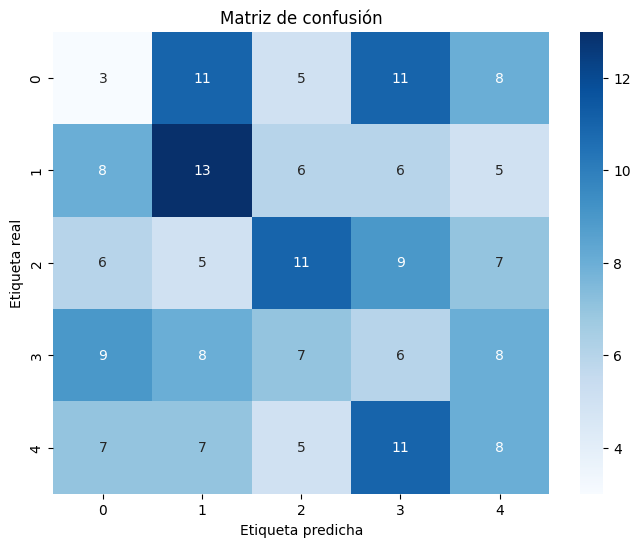

In [ ]:
matriz_conf = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(matriz_conf, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de confusión")
plt.xlabel("Etiqueta predicha")
plt.ylabel("Etiqueta real")
plt.show()

In [ ]:
model.save('model.h5')